# Example climb: Matching means and standard deviations with maximum structural diversity

## 1. Notebook setup

### 1.1. Imports


In [1]:
import pickle
import sys
from itertools import combinations

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats

sys.path.append('..')

from hill_climber import HillClimber

### 1.2. Run hyperparameters

In [2]:
# Number of input data points
n = 1000

# Run duration in minutes
run_time = 30

# Number of replicate climbs for each objective function
replicates = 4

# Hill climb parameters
step_size = 0.05
perturb_fraction = 0.05
temperature = 1000
initial_noise = 0.2
cooling_rate = 0.9999

### 1.3. Input distributions

Initial statistics:
Mean w: 10.0387
Mean x: 10.1417
Mean y: 10.0117
Mean z: 9.9626

Initial pairwise KS statistics (similarity):
w-x: 0.0450
w-y: 0.0210
w-z: 0.0400
x-y: 0.0470
x-z: 0.0600
y-z: 0.0380


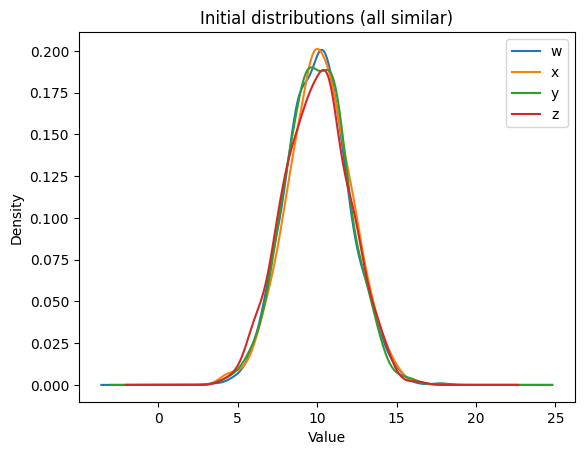

In [3]:
# Create input distributions (4 variables, all strictly positive)
# Start with similar normal distributions that will be evolved into different structures
np.random.seed(42)  # For reproducibility

data = pd.DataFrame({
    'w': np.random.normal(loc=10.0, scale=2.0, size=n),
    'x': np.random.normal(loc=10.0, scale=2.0, size=n),
    'y': np.random.normal(loc=10.0, scale=2.0, size=n),
    'z': np.random.normal(loc=10.0, scale=2.0, size=n)
})

# Ensure all values are strictly positive by clipping any negative values
for col in data.columns:
    data[col] = np.maximum(data[col], 0.1)  # Minimum value of 0.1

print("Initial statistics:")

for col in data.columns:
    print(f"Mean {col}: {np.mean(data[col]):.4f}")

print(f"\nInitial pairwise KS statistics (similarity):")

for col1, col2 in combinations(data.columns, 2):
    ks_stat, _ = stats.ks_2samp(data[col1], data[col2])
    print(f"{col1}-{col2}: {ks_stat:.4f}")

# Visualize using KDE plots to show initial distribution shapes
fig, ax = plt.subplots()

for col in data.columns:
    data[col].plot.kde(label=col, ax=ax)

plt.title('Initial distributions (all similar)')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.show()

## 2. Maximize structural diversity while preserving mean and standard deviation similarity

### 2.1. Objective function


In [4]:
def objective_similar_means_stds_diverse_structures(w, x, y, z):
    '''Maximize structural diversity while maintaining similar means and standard deviations.
    
    Objective function: mean_ks_statistic - penalty_weight * (mean_penalty + std_penalty)
    
    This encourages:
        - Similar means across all 4 distributions (w, x, y, z)
        - Similar standard deviations across all 4 distributions
        - Maximum structural diversity between distributions (high pairwise KS statistics)
    
    The objective constrains both first and second moments while maximizing shape differences.
    
    Args:
        w, x, y, z: Four variables (array-like)
    
    Returns:
        Tuple of (metrics_dict, objective_value) where:
            - metrics_dict: Dict with means, stds, KS statistics, and penalties
            - objective_value: mean_ks_statistic - penalty_weight * (mean_penalty + std_penalty)
    '''
    
    # Calculate means for all 4 distributions
    means = {
        'w': np.mean(w),
        'x': np.mean(x), 
        'y': np.mean(y),
        'z': np.mean(z)
    }
    
    # Calculate standard deviations for all 4 distributions
    stds = {
        'w': np.std(w),
        'x': np.std(x),
        'y': np.std(y),
        'z': np.std(z)
    }
    
    # Calculate target mean and std (average across all distributions)
    target_mean = np.mean(list(means.values()))
    target_std = np.mean(list(stds.values()))
    
    # Calculate mean penalty - how far each mean is from the target
    mean_deviations = [abs(mean_val - target_mean) for mean_val in means.values()]
    mean_penalty = np.mean(mean_deviations)  # Absolute deviation, no normalization
    
    # Calculate std penalty - how far each std is from the target
    std_deviations = [abs(std_val - target_std) for std_val in stds.values()]
    std_penalty = np.mean(std_deviations)  # Absolute deviation, no normalization
    
    # Calculate pairwise KS statistics to measure structural diversity
    distributions = {'w': w, 'x': x, 'y': y, 'z': z}
    ks_statistics = {}
    ks_values = []
    
    for name1, name2 in combinations(distributions.keys(), 2):
        ks_stat, _ = stats.ks_2samp(distributions[name1], distributions[name2])
        ks_statistics[f'KS_{name1}_{name2}'] = ks_stat
        ks_values.append(ks_stat)
    
    # Mean KS statistic - higher means more structural diversity
    mean_ks_statistic = np.mean(ks_values)
    min_ks_statistic = np.min(ks_values)
    max_ks_statistic = np.max(ks_values)
    
    # Objective: maximize structural diversity while maintaining similar means and stds
    # Scale KS statistic to similar magnitude as penalties (KS in [0,1], multiply by 10)
    penalty_weight = 5.0  # Balance between diversity and constraint satisfaction
    combined_penalty = mean_penalty + std_penalty
    objective = (10.0 * mean_ks_statistic) - (penalty_weight * combined_penalty)
    
    # Compile metrics
    metrics = {
        'Mean W': means['w'],
        'Mean X': means['x'],
        'Mean Y': means['y'],
        'Mean Z': means['z'],
        'Std W': stds['w'],
        'Std X': stds['x'],
        'Std Y': stds['y'],
        'Std Z': stds['z'],
        'Target Mean': target_mean,
        'Target Std': target_std,
        'Mean Penalty': mean_penalty,
        'Std Penalty': std_penalty,
        'Combined Penalty': combined_penalty,
        'Mean KS Statistic': mean_ks_statistic,
        'Min KS Statistic': min_ks_statistic,
        'Max KS Statistic': max_ks_statistic,
        **ks_statistics  # Add individual pairwise KS statistics
    }
    
    return metrics, objective


### 2.2. Hill climbing run

In [5]:
# Create HillClimber instance
climber = HillClimber(
    data=data,
    objective_func=objective_similar_means_stds_diverse_structures,
    max_time=run_time,
    step_size=step_size,
    perturb_fraction=perturb_fraction,
    temperature=temperature,
    cooling_rate=cooling_rate,
    mode='maximize'
)

# Run parallel optimization
results = climber.climb_parallel(
    replicates=replicates,
    initial_noise=initial_noise
)

### 2.3. Results

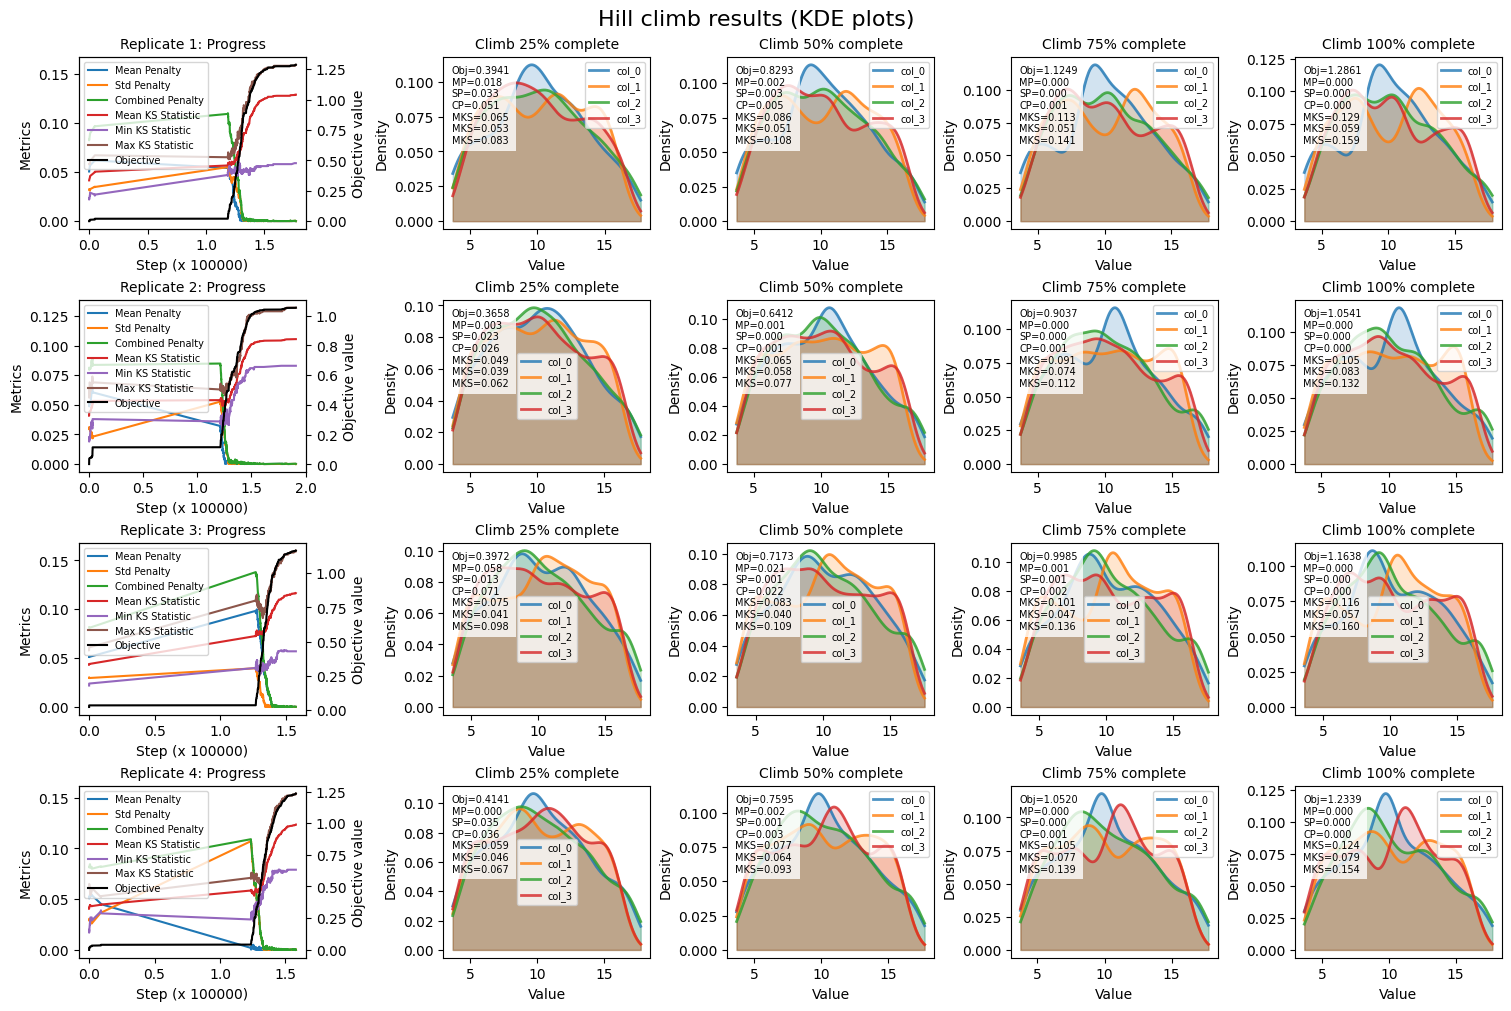

In [6]:
# Display key metrics using histograms
climber.plot_results(
    results,
    plot_type='histogram', 
    metrics=[
        'Mean Penalty',
        'Std Penalty',
        'Combined Penalty',
        'Mean KS Statistic',
        'Min KS Statistic',
        'Max KS Statistic'
    ]
)


### 2.4. Best result visualization

BEST RESULT VISUALIZATION
Best replicate: 1
Final objective: 1.2861

Final statistics:
  W: mean=10.19, std=3.49
  X: mean=10.19, std=3.49
  Y: mean=10.19, std=3.49
  Z: mean=10.19, std=3.49


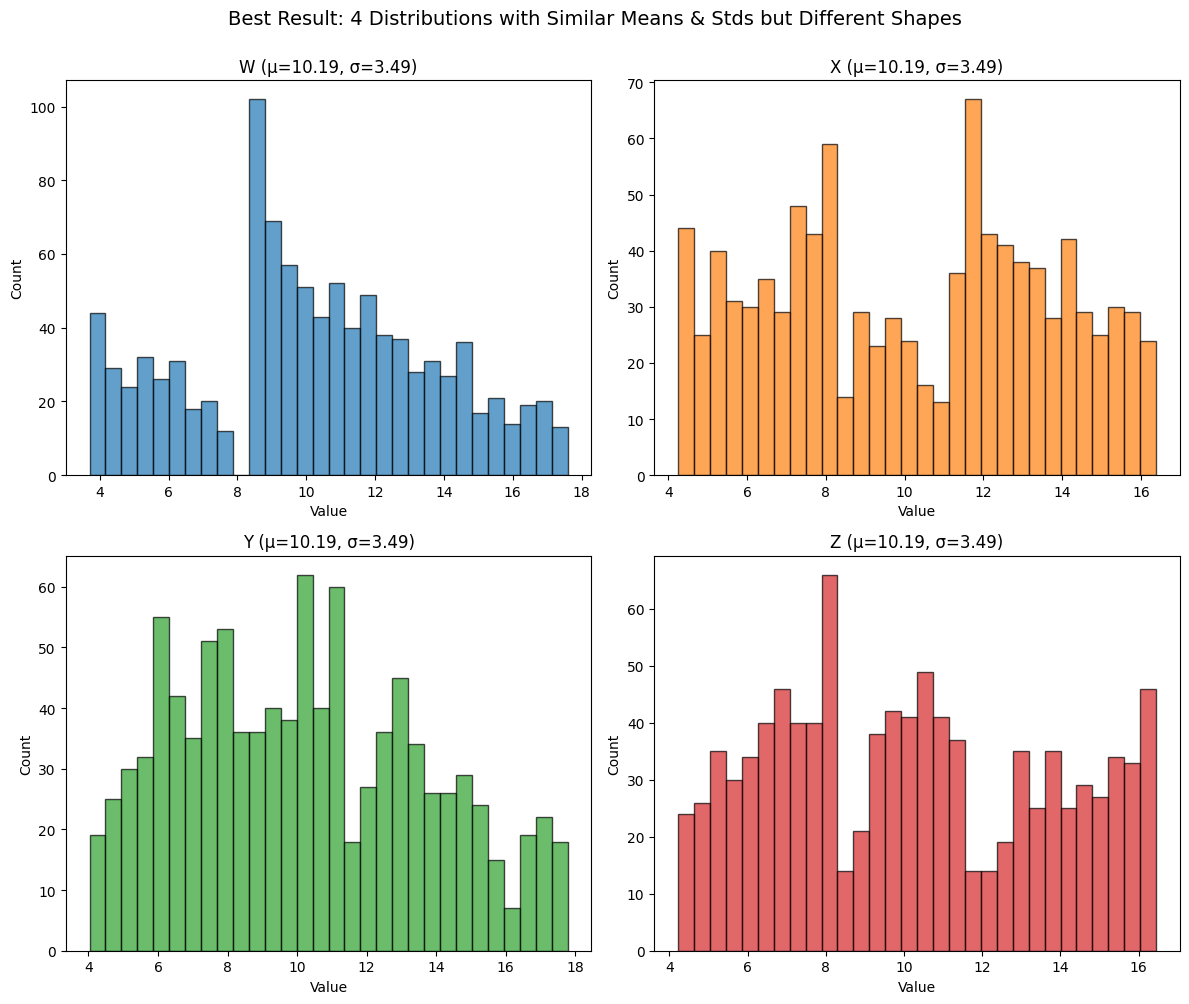

In [7]:
# Visualize the best result's distributions
print("="*60)
print("BEST RESULT VISUALIZATION")
print("="*60)

# Find the replicate with highest objective value
best_idx = np.argmax([steps_df['Objective value'].iloc[-1] 
                      for _, _, steps_df in results['results']])
noisy_initial_best, best_data_final, best_steps = results['results'][best_idx]

print(f"Best replicate: {best_idx + 1}")
print(f"Final objective: {best_steps['Objective value'].iloc[-1]:.4f}")
print()

# Print final statistics
print("Final statistics:")
for col in best_data_final.columns:
    print(f"  {col.upper()}: mean={np.mean(best_data_final[col]):.2f}, std={np.std(best_data_final[col]):.2f}")

# Plot individual histograms for each distribution
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for i, col in enumerate(best_data_final.columns):
    ax = axes[i]
    ax.hist(best_data_final[col], bins=30, color=colors[i], edgecolor='black', alpha=0.7)
    ax.set_title(f'{col.upper()} (μ={np.mean(best_data_final[col]):.2f}, σ={np.std(best_data_final[col]):.2f})', 
                 fontsize=12)
    ax.set_xlabel('Value')
    ax.set_ylabel('Count')

fig.suptitle('Best Result: 4 Distributions with Similar Means & Stds but Different Shapes', 
             fontsize=14, y=1.00)
plt.tight_layout()
plt.show()


In [8]:
# Save the climber object
with open('../data/03_similar_means_diverse_structures.pkl', 'wb') as f:
    pickle.dump(climber, f)

## 3. Resume optimization for additional 30 minutes

### 3.1. Load saved climber and resume

In [ ]:
# Load the saved climber object
with open('../data/03_similar_means_diverse_structures.pkl', 'rb') as f:
    loaded_climber = pickle.load(f)

# Resume optimization for an additional 30 minutes
print("Resuming optimization for an additional 30 minutes...")
print(f"Previous run time: {loaded_climber.max_time} minutes")
print(f"Additional run time: 30 minutes")
print()

# Update max_time for the additional 30 minutes
loaded_climber.max_time = 30

# Continue the optimization
resumed_results = loaded_climber.climb_parallel(
    replicates=replicates,
    initial_noise=initial_noise
)

Resuming optimization for an additional 30 minutes...
Previous run time: 30 minutes
Additional run time: 30 minutes



### 3.2. Resumed optimization results

In [ ]:
# Display key metrics from resumed optimization
loaded_climber.plot_results(
    resumed_results,
    plot_type='histogram', 
    metrics=[
        'Mean Penalty',
        'Std Penalty',
        'Combined Penalty',
        'Mean KS Statistic',
        'Min KS Statistic',
        'Max KS Statistic'
    ]
)

### 3.3. Best resumed result visualization

In [ ]:
# Visualize the best result's distributions from resumed optimization
print("="*60)
print("BEST RESUMED RESULT VISUALIZATION")
print("="*60)

# Find the replicate with highest objective value
best_idx_resumed = np.argmax([steps_df['Objective value'].iloc[-1] 
                               for _, _, steps_df in resumed_results['results']])
noisy_initial_resumed, best_data_resumed, best_steps_resumed = resumed_results['results'][best_idx_resumed]

print(f"Best replicate: {best_idx_resumed + 1}")
print(f"Final objective: {best_steps_resumed['Objective value'].iloc[-1]:.4f}")
print()

# Print final statistics
print("Final statistics:")
for col in best_data_resumed.columns:
    print(f"  {col.upper()}: mean={np.mean(best_data_resumed[col]):.2f}, std={np.std(best_data_resumed[col]):.2f}")

# Plot individual histograms for each distribution
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for i, col in enumerate(best_data_resumed.columns):
    ax = axes[i]
    ax.hist(best_data_resumed[col], bins=30, color=colors[i], edgecolor='black', alpha=0.7)
    ax.set_title(f'{col.upper()} (μ={np.mean(best_data_resumed[col]):.2f}, σ={np.std(best_data_resumed[col]):.2f})', 
                 fontsize=12)
    ax.set_xlabel('Value')
    ax.set_ylabel('Count')

fig.suptitle('Best Resumed Result: 4 Distributions with Similar Means & Stds but Different Shapes', 
             fontsize=14, y=1.00)
plt.tight_layout()
plt.show()

In [ ]:
# Save the resumed climber object
with open('../data/03_similar_means_diverse_structures_resumed.pkl', 'wb') as f:
    pickle.dump(loaded_climber, f)

print("Resumed results saved to '../data/03_similar_means_diverse_structures_resumed.pkl'")